# Results

In [108]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
from phd.pipelines.predict.nodes import score
import vessel_manoeuvring_models.models.IMO_simulations
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess

In [110]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

df_VCT = catalog.load(f"{ship}.df_VCT")
resistance_MDL = catalog.load(f"{ship}.resistance_MDL")
tests_ek = catalog.load(f"{ship}.tests_ek2")

mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion

time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
#tests_ek_smooth_joined = catalog.load(f"{ship}.tests_ek_smooth_joined")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

df_VCT = catalog.load(f"{ship}.df_VCT")
mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion


[02/05/24 09:23:37] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=615803;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=861656;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=165638;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/24 09:23:38] INFO     Loading data from 'wPCC.resistance_MDL' (CSVDataSet)...            ]8;id=926939;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=38126;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek2' (PartitionedDataset)...         ]8;id=305618;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=924570;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=2817;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=797140;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=836456;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=222598;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/24 09:23:39] INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=214792;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=101155;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [111]:
loaders = {
        
    'Reference model' : catalog.load(f"{ship}.models_VCT_MDL")['semiempirical_covered'],
    'Physics informed ID' : catalog.load(f"{ship}.models_ID_hull2")['semiempirical_covered'],
    
    #'Abkowitz VCT': catalog.load(f"{ship}.models_rudder_VCT_MDL")['Abkowitz'],
    'Abkowitz ID' : catalog.load(f"{ship}.models_ID_hull_rudder2")['Abkowitz'],
    #'Martins simple ID' : catalog.load(f"{ship}.models_ID_hull_rudder2")['Martins simple'],


}

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=889399;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=5031;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull2' (PartitionedDataset)...   ]8;id=183958;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=792265;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder2'                    ]8;id=951700;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=404100;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [112]:
models = {name:loader() for name,loader in loaders.items()}

In [113]:
#models['Abkowitz VCT'].parameters['Nr']=-0.002195593689997491*1.25
#models['Abkowitz VCT'].parameters['Nrdot']=-0.0001566124359115707*0.3

## Inverse dynamics

In [114]:
model=models['Reference model']

[02/05/24 09:23:53] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:253:        ]8;id=247095;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=502279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

[02/05/24 09:23:54] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:253:        ]8;id=601960;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=478539;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

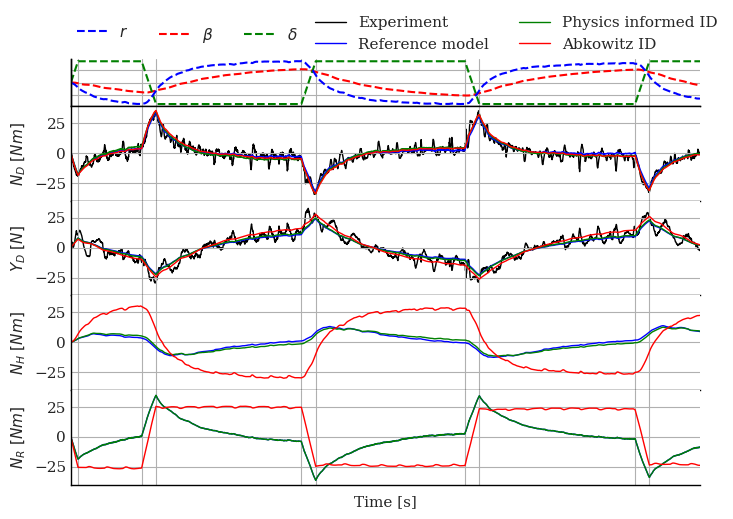

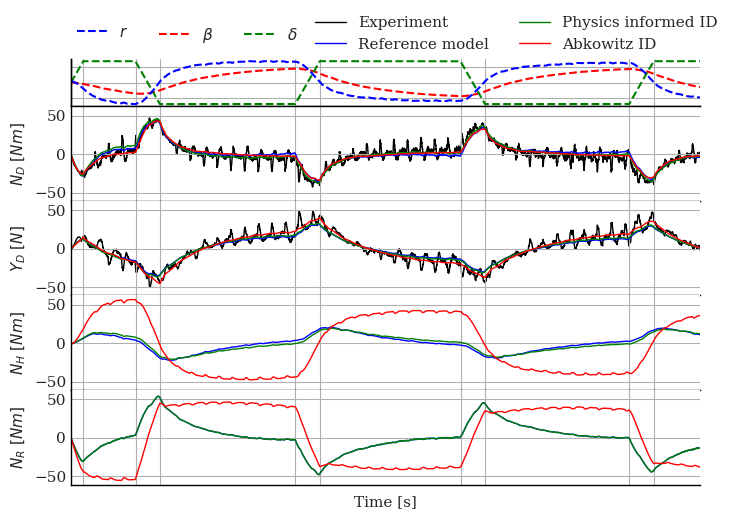

In [115]:
ids = [
    22770,
    22773,
]
for id in ids:
    #loader = tests_ek_smooth[str(id)]
    loader = tests_ek[str(id)]
    data = loader()
    data = preprocess(data,ship_data=ship_data)

    angle = zigzag_angle(data_MDL=data)
    
    fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data, styles=styles, keys=['N_D','Y_D','N_H','N_R']);
    fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 2.0), ncol=1)
    fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 2.0), ncol=3)
    #fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 2.52), ncol=2)
    fig.axes[1].legend(bbox_to_anchor=(1.05, 2.1), ncol=2)
    
    #fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data, styles=styles, keys=['Y_D','Y_H','Y_R']);
    #fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.3, 2), ncol=1)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 2), ncol=3)
    #fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=2)
    #fig.savefig(paper.file_path_with_nb_ref(f"ID_Y_zigzag{int(angle)}.svg"))

    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(paper.file_path_with_nb_ref(f"ID_zigzag{int(angle)}.pdf"),bbox_inches="tight")

## Closed loop simulation

[02/05/24 09:24:01] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=991586;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=356776;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

[02/05/24 09:24:06] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=39019;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=731548;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:127: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

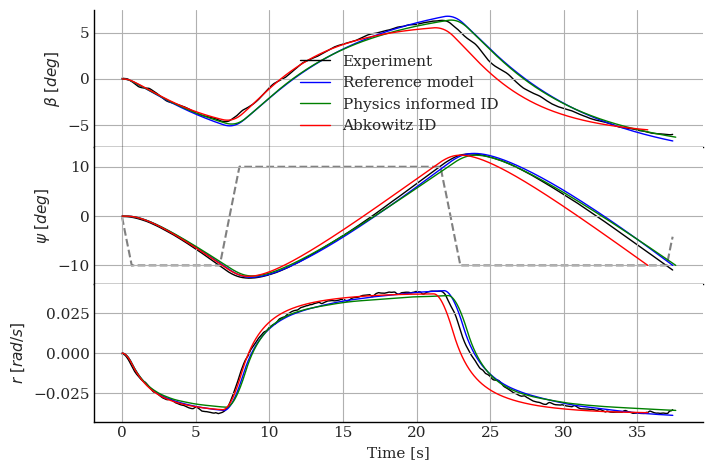

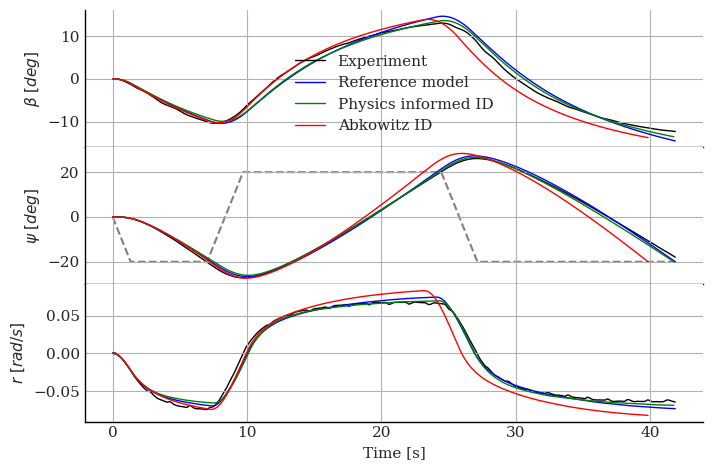

In [116]:
for id in ids:
    loader = tests_ek[str(id)]
    data = loader()
    data = preprocess(data,ship_data=ship_data)
    angle = zigzag_angle(data_MDL=data)

    dataframes = {
    'Experiment': data,
    }

    for model_name, model in models.items():
        #if 'thrust' in model.control_keys:
        #    model.control_keys.remove('thrust')
        dataframes[model_name] = simulate_closed_loop(model=model,data=data)

    dataframes['Experiment'] = dataframes['Experiment'].loc[0:dataframes['Reference model'].index[-1]].copy()
    
    dataframes['Experiment']['-delta_deg']=-dataframes['Experiment']['delta_deg']
    fig = plot(dataframes=dataframes, keys=['beta_deg','r','psi_deg'], styles=styles, ncols=1);
    fig.axes[0].legend(loc='best')
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.axes[0].set_ylabel(r'$\beta$ $[deg]$')
    fig.axes[1].set_ylabel(r'$\psi$ $[deg]$')
    fig.axes[1].plot(dataframes['Experiment'].index,dataframes['Experiment']['-delta_deg'],'--',color='gray',zorder=-10)
    fig.axes[2].set_ylabel(r'$r$ $[rad/s]$')
    
    fig.savefig(paper.file_path_with_nb_ref(f"closed_loop_zigzag{int(angle)}.svg"),bbox_inches="tight")

## Parameter decomposition
The predicted forces can be decomposed into the various parameter contributions. It can be seen that the `model` and `Abkowitz` have very different decompositions, eventhough the simulations results above are similar. The contributions from the Nr and Nrrr coefficients are very large for the `Abkowitz`.

[02/05/24 09:24:07] WARNING  /tmp/ipykernel_1536/3264770082.py:51: UserWarning: This figure was     ]8;id=509196;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=363686;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             using a layout engine that is incompatible with subplots_adjust and/or                
                             tight_layout; not calling subplots_adjust.                                            
                               plt.subplots_adjust(wspace=0, hspace=0)                                             
                                                                                                                   

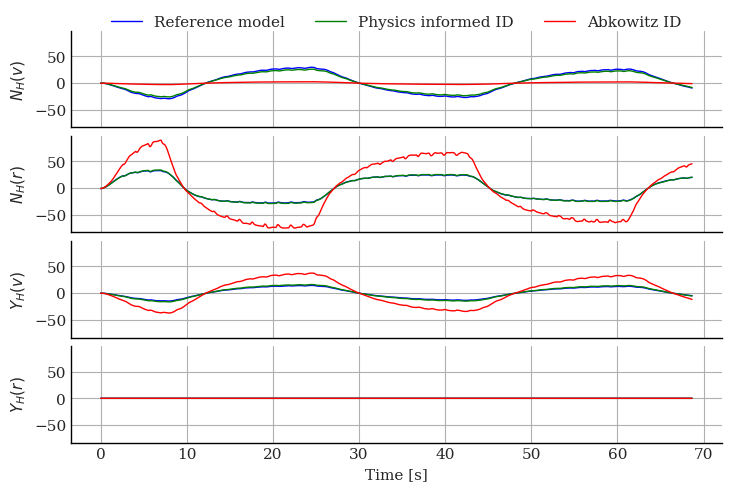

In [117]:
id = 22773
loader = tests_ek[str(id)]
data = loader()
data = preprocess(data,ship_data=ship_data)

model = models['Reference model']
df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)

df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr'], inplace=True)
renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
df_joined_parameter_contributions.rename(columns=renames, inplace=True)


fig,axes=plt.subplots(nrows=len(df_joined_parameter_contributions.columns))
for model_name,model in models_.items():

    df_joined_parameter_contributions_N = joined_parameter_contributions(model=model, data=data, prefix='N', unit='moment')
    df_joined_parameter_contributions_Y = joined_parameter_contributions(model=model, data=data, prefix='Y', unit='force')
    df_joined_parameter_contributions = pd.concat((df_joined_parameter_contributions_N,df_joined_parameter_contributions_Y),axis=1)
    
    df_joined_parameter_contributions.drop(columns=['Yvrr+Yvvr','Nvrr+Nvvr'], inplace=True)
        
    renames = {
        'Nv+Nvvv':r'$N_H(v)$',
        'Nr+Nrrr':r'$N_H(r)$',
        'Yv+Yvvv':r'$Y_H(v)$',
        'Yr+Yrrr':r'$Y_H(r)$',
    }
    df_joined_parameter_contributions.rename(columns=renames, inplace=True)
    
    for ax,(group_name, values) in zip(axes,df_joined_parameter_contributions.items()):
        values.plot(ax=ax, **styles[model_name])
        ax.set_ylabel(group_name)
        ax.set_xlabel('Time [s]')
        ax.grid(True)

same_ylims(axes)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)
for ax in axes[0:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig(paper.file_path_with_nb_ref("hull_force_decomposition_zigzag20.svg"))